# Methoden en Technieken -- Blok 2

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een **geschikte architectuur** voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, **deep learning**, **kennisrepresentatie**, **computer vision** en natural language processing.
- B3: Je prepareert een dataset voor het **trainen en testen** van een AI-model rekening houdend met technische en ethische randvoorwaarden.
- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een **iteratief proces**.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

## De opdracht

In de slides van les 12 word beschreven hoe we een Deep Belief Netwerk unsupervised trainen op de MNIST data. 

In deze opdracht gaan we dit gebruiken om een MNIST classifier semi-supervised te trainen. We doen hier alsof slechts 500 van de 70000 MNIST afbeeldingen gelabeld zijn (zie code hieronder, deze maakt de data aan die je mag gebruiken). Je zult dus:
- Een DBN unsupervised trainen op de data
- Een classifier trainen op de latent space van de DBN en de gelabelde data

Je mag zelf kiezen:
- De architectuur van de DBN (let op, deze zal wat tijd kosten om te trainen)
- De classifier op de latent space (alles is toegestaan)
- Hoe je de modellen beoordeelt

Probeer een zo'n goed mogelijk model te krijgen (in een redelijke tijd), verantwoord je keuzes. Bespreek je uiteindelijke model in detail, eerdere pogingen/modellen mogen korter besproken worden.


In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import BernoulliRBM
from ipywidgets import interactive
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import torch.nn.functional as F
from sklearn.dummy import DummyClassifier

In [222]:
(x1, y), (x2, _) = keras.datasets.mnist.load_data()
x = np.concatenate((x1, x2))

x = np.expand_dims(x, -1).astype("float32") / 255

y = y[:500]

del x1, x2

In [223]:
# Select the first 500 labels as labeled data
labeled_x = x[:500]
labeled_y = y[:500]

# The rest are unlabeled data
unlabeled_x = x[500:]

In [224]:
X_labeled_train, x_labeled_remaining, y_labeled_train,  y_labeled_remaining = train_test_split(labeled_x, labeled_y, test_size=0.2, random_state = 42)
X_labeled_validation, X_labeled_test,y_labeled_validation,  y_test = train_test_split(x_labeled_remaining, y_labeled_remaining, test_size=0.5, random_state = 42)
y_labeled_train = keras.utils.to_categorical(y_labeled_train, 10)
y_labeled_validation = keras.utils.to_categorical(y_labeled_validation, 10)
y_labeled_test = keras.utils.to_categorical(y_test, 10)

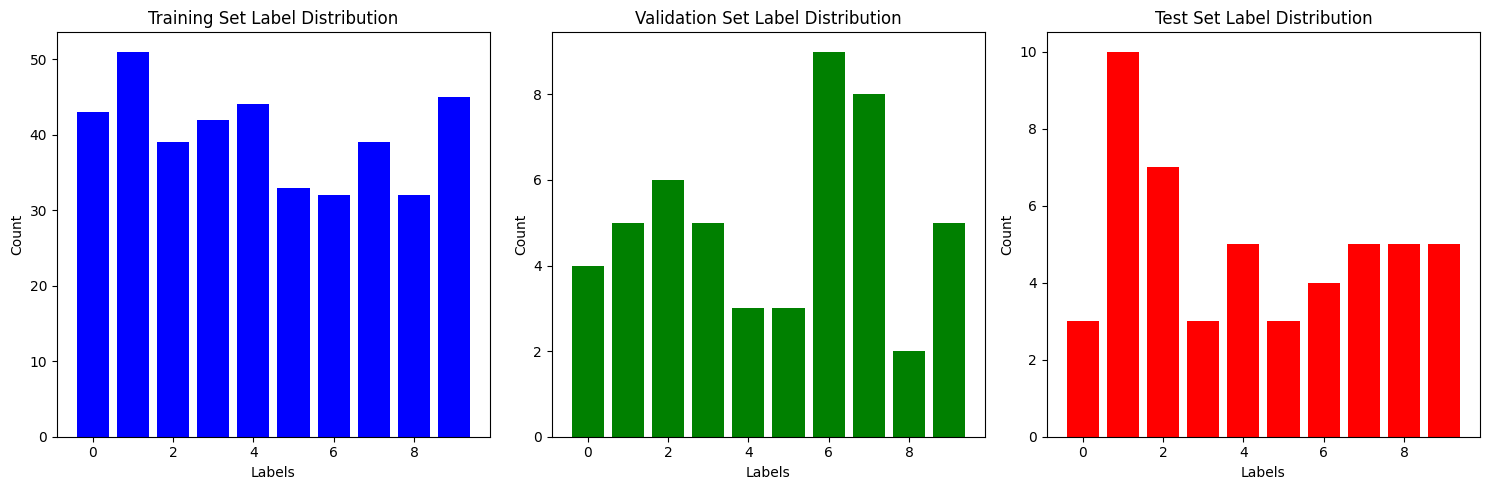

In [225]:
# Convert one-hot encoded labels back to single integer labels
y_train_labels = np.argmax(y_labeled_train, axis=1)
y_val_labels = np.argmax(y_labeled_validation, axis=1)
y_test_labels = np.argmax(y_labeled_test, axis=1)

# Count the number of occurrences of each label
train_label_counts = np.bincount(y_train_labels)
val_label_counts = np.bincount(y_val_labels)
test_label_counts = np.bincount(y_test_labels)

# Define the labels
labels = range(10)

# Plot the label counts for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, train_label_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')

plt.subplot(1, 3, 2)
plt.bar(labels, val_label_counts, color='green')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')

plt.subplot(1, 3, 3)
plt.bar(labels, test_label_counts, color='red')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Test Set Label Distribution')

plt.tight_layout()
plt.show()

The data is niceley split, but some labels are a bit sparce so it a new and stratisfied split would be a good idea.

In [226]:
X_labeled_train, x_labeled_remaining, y_labeled_train,  y_labeled_remaining = train_test_split(labeled_x, labeled_y, test_size=0.2, random_state = 42, stratify=labeled_y)
X_labeled_validation, X_labeled_test,y_labeled_validation,  y_test = train_test_split(x_labeled_remaining, y_labeled_remaining, test_size=0.5, random_state = 42, stratify=y_labeled_remaining)
y_labeled_train = keras.utils.to_categorical(y_labeled_train, 10)
y_labeled_validation = keras.utils.to_categorical(y_labeled_validation, 10)
y_labeled_test = keras.utils.to_categorical(y_test, 10)

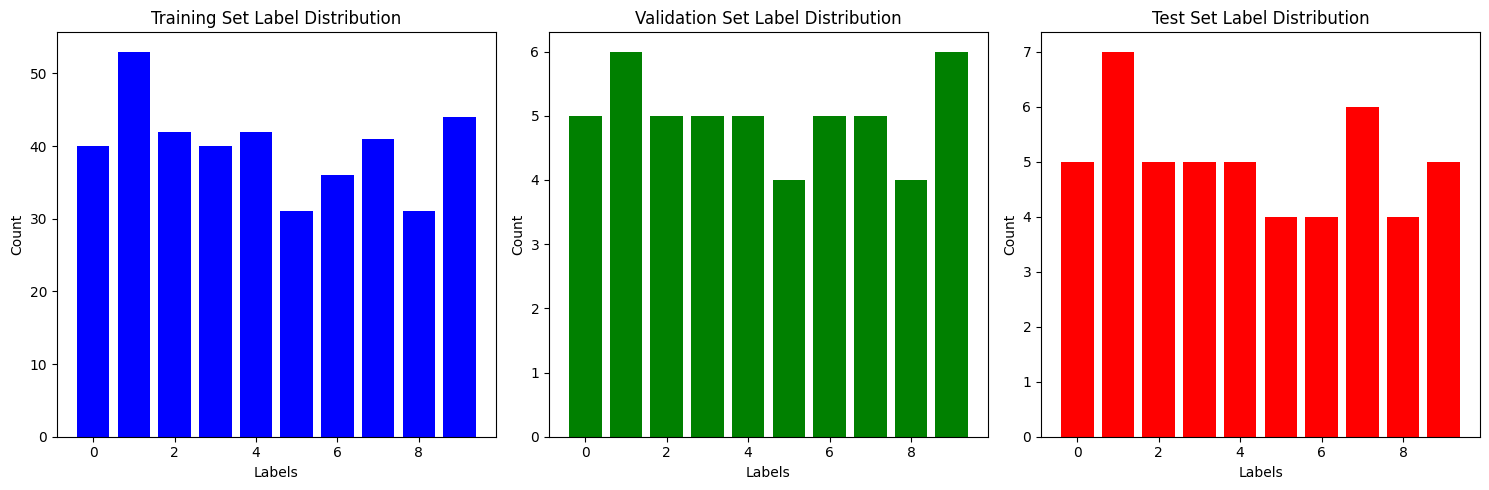

In [227]:
# Convert one-hot encoded labels back to single integer labels
y_train_labels = np.argmax(y_labeled_train, axis=1)
y_val_labels = np.argmax(y_labeled_validation, axis=1)
y_test_labels = np.argmax(y_labeled_test, axis=1)

# Count the number of occurrences of each label
train_label_counts = np.bincount(y_train_labels)
val_label_counts = np.bincount(y_val_labels)
test_label_counts = np.bincount(y_test_labels)

# Define the labels
labels = range(10)

# Plot the label counts for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, train_label_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')

plt.subplot(1, 3, 2)
plt.bar(labels, val_label_counts, color='green')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')

plt.subplot(1, 3, 3)
plt.bar(labels, test_label_counts, color='red')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Test Set Label Distribution')

plt.tight_layout()
plt.show()

# Jelmar

Not only is there plenty of data for each label now, the proportions of the labels is also the same in each dataset.

In [229]:
unlabeled_x = unlabeled_x.reshape(len(unlabeled_x), -1)
X_labeled_train = X_labeled_train.reshape(len(X_labeled_train), -1)
X_labeled_validation = X_labeled_validation.reshape(len(X_labeled_validation), -1)
X_labeled_test = X_labeled_test.reshape(len(X_labeled_test), -1)

# Evaluation metrics


# Jelmar

The evaluation metrics used will be the accuracy score.

Accuracy has been chosen because no single number is more important than another, and the dataset is perfectly balanced, so there is no risk of any label being overlooked.

# Null model

# Jelmar
Het nulmodel will be the most frequent number.

In [219]:
# Convert one-hot encoded labels back to class labels
y_train = np.argmax(y_labeled_train, axis=1)
y_val = np.argmax(y_labeled_test, axis=1)

# Create the DummyClassifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier on the training data
dummy_clf.fit(X_labeled_train, y_train)

# Predict on the validation data
y_pred_classes = dummy_clf.predict(X_labeled_validation)

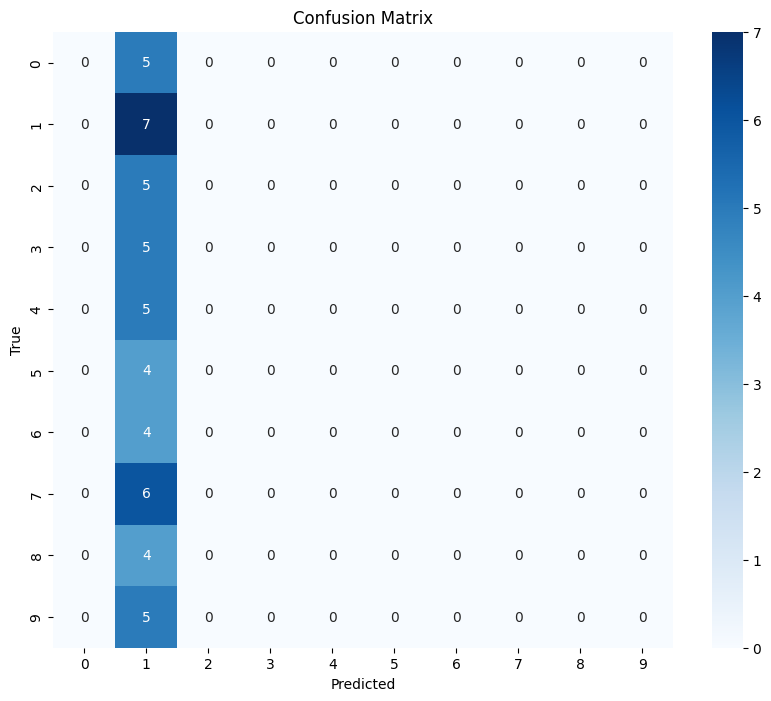

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.14      1.00      0.25         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         5

    accuracy                           0.14        50
   macro avg       0.01      0.10      0.02        50
weighted avg       0.02      0.14      0.03        50



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [237]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_val, y_pred_classes))

The accuracy of the null model is 14%.

# Itteratie 0

In [240]:
hidden_sizes = [364, 91, 45]

In [241]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.52s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.34s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.36s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.44s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.43s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.43s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.45s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.50s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.45s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.49s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.54s
[BernoulliRBM] Iteration

The pseudo-likelihood is how confident the model is in predicting, but it does not say if the model is overfitting or underfitting.

In [242]:
with open('DBN_2B_0.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [243]:
with open('DBN_2B_0.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [244]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

RBM inner representatation of the number.

In [245]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))
        

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

How good the model is at recognising the numbers.

In [246]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

So the activation function of the RBM layers has to be sigmoid for it to work with the bias enabled.

To start small there is only one pytorch layer after the RBM with 10 nodes because that is also the output of the model.

For the last activation function, I was considering between sigmoid and ReLU. Sigmoid would extend the RBM formula to the output layer, maintaining consistency with the previous layers. However, ReLU would introduce its own non-linearity independently. Given that the sigmoid function originates from a different type of model (RBM), I decided to let the PyTorch layer operate independently and chose ReLU. Other activation function will be tested in later iterations.

In [247]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        
        x = torch.relu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


# Jelmar
The criterion CrossEntropyLoss will be used since that is the standart for multilabel classification.

The optimizer Adam will be used with the default parameters including the default learning rate of 0.001.

The batch size is set to 2 because there are only 10 nodes being trained and with a small dataset a small batch size means more knowledge per item.

In [248]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses1 = []
val_losses1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.4322, Val Loss: 1.9733
Epoch [2/100], Loss: 2.5270, Val Loss: 1.7057
Epoch [3/100], Loss: 2.5847, Val Loss: 1.5270
Epoch [4/100], Loss: 2.6086, Val Loss: 1.3985
Epoch [5/100], Loss: 2.6270, Val Loss: 1.3005
Epoch [6/100], Loss: 2.6800, Val Loss: 1.2309
Epoch [7/100], Loss: 2.6288, Val Loss: 1.1706
Epoch [8/100], Loss: 2.6196, Val Loss: 1.1244
Epoch [9/100], Loss: 2.6222, Val Loss: 1.0849
Epoch [10/100], Loss: 2.5921, Val Loss: 1.0525
Epoch [11/100], Loss: 2.6179, Val Loss: 1.0273
Epoch [12/100], Loss: 2.6030, Val Loss: 1.0021
Epoch [13/100], Loss: 2.5732, Val Loss: 0.9817
Epoch [14/100], Loss: 2.5833, Val Loss: 0.9647
Epoch [15/100], Loss: 2.5532, Val Loss: 0.9446
Epoch [16/100], Loss: 2.5301, Val Loss: 0.9317
Epoch [17/100], Loss: 2.5611, Val Loss: 0.9208
Epoch [18/100], Loss: 2.4976, Val Loss: 0.9040
Epoch [19/100], Loss: 2.5012, Val Loss: 0.8948
Epoch [20/100], Loss: 2.5029, Val Loss: 0.8889
Epoch [21/100], Loss: 2.4841, Val Loss: 0.8783
Epoch [22/100], Loss: 

In [249]:
# Save the model
torch.save(model.state_dict(), 'model_0.pth')
print("Model saved!")

Model saved!


In [250]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_0.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6264\1992985865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_0.pth'))


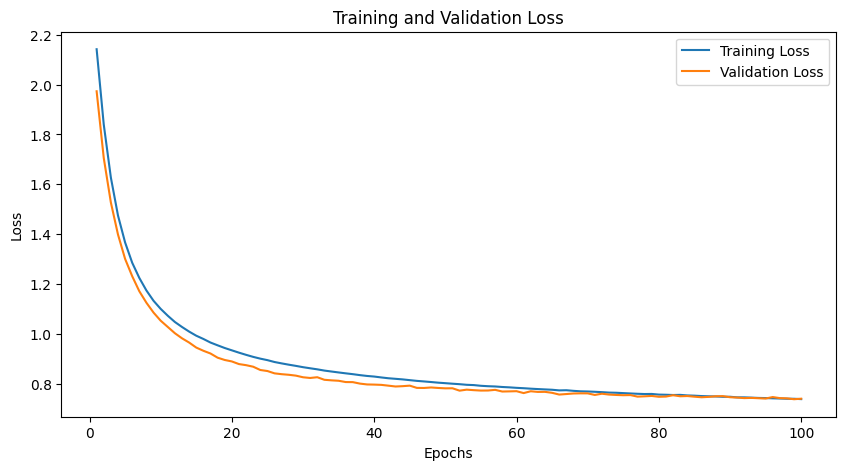

In [251]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

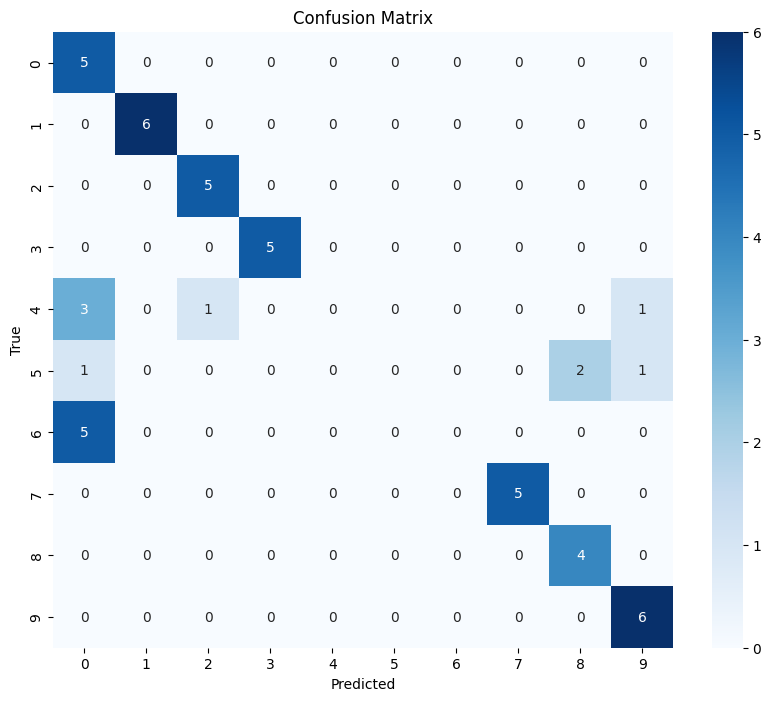

              precision    recall  f1-score   support

           0       0.36      1.00      0.53         5
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           7       1.00      1.00      1.00         5
           8       0.67      1.00      0.80         4
           9       0.75      1.00      0.86         6

    accuracy                           0.72        50
   macro avg       0.56      0.70      0.61        50
weighted avg       0.58      0.72      0.63        50



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [252]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))


# Itteratie 1

On the first itteration the activation fuction of the pytorch layer will be changed, because there are other activation function that work better together with sigmoid than relu.

In [238]:
hidden_sizes = [364, 91, 45]

In [239]:
with open('DBN_2B_0.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In iteration 0 I had to start simple.

There I was wondering if I shoud choose to keep the math of the models independend or connected, but there is also the silu function that is both the relu and sigmoid activation functions at once.

In [118]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [119]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses_1 = []
val_losses_1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses_1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses_1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.0346, Val Loss: 1.9505
Epoch [2/100], Loss: 1.3615, Val Loss: 1.4324
Epoch [3/100], Loss: 0.9896, Val Loss: 1.0283
Epoch [4/100], Loss: 0.7850, Val Loss: 0.7970
Epoch [5/100], Loss: 0.6205, Val Loss: 0.6576
Epoch [6/100], Loss: 0.5422, Val Loss: 0.5702
Epoch [7/100], Loss: 0.4515, Val Loss: 0.4989
Epoch [8/100], Loss: 0.4126, Val Loss: 0.4521
Epoch [9/100], Loss: 0.3444, Val Loss: 0.4158
Epoch [10/100], Loss: 0.3416, Val Loss: 0.3859
Epoch [11/100], Loss: 0.3435, Val Loss: 0.3578
Epoch [12/100], Loss: 0.3133, Val Loss: 0.3372
Epoch [13/100], Loss: 0.2263, Val Loss: 0.3229
Epoch [14/100], Loss: 0.2407, Val Loss: 0.3070
Epoch [15/100], Loss: 0.2200, Val Loss: 0.2927
Epoch [16/100], Loss: 0.2190, Val Loss: 0.2868
Epoch [17/100], Loss: 0.2106, Val Loss: 0.2697
Epoch [18/100], Loss: 0.1790, Val Loss: 0.2567
Epoch [19/100], Loss: 0.1539, Val Loss: 0.2484
Epoch [20/100], Loss: 0.1481, Val Loss: 0.2386
Epoch [21/100], Loss: 0.1340, Val Loss: 0.2321
Epoch [22/100], Loss: 

In [121]:
# Save the model
torch.save(model.state_dict(), 'model_1.pth')
print("Model saved!")

Model saved!


In [122]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_1.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6264\3365279233.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_1.pth'))


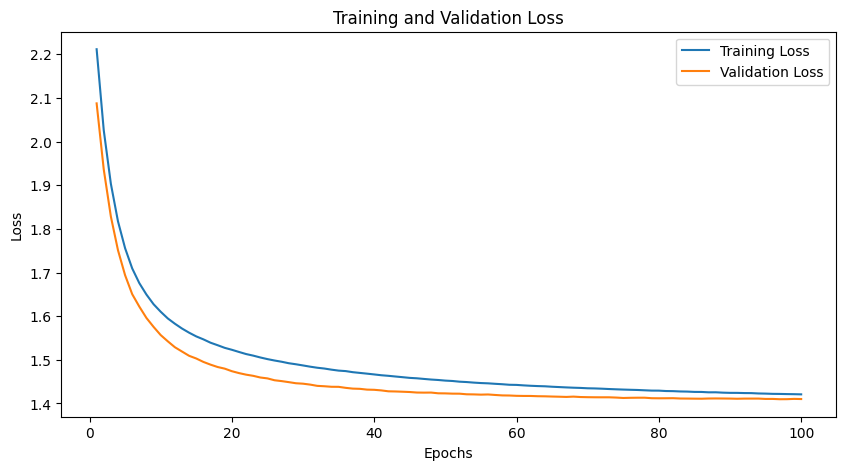

In [123]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

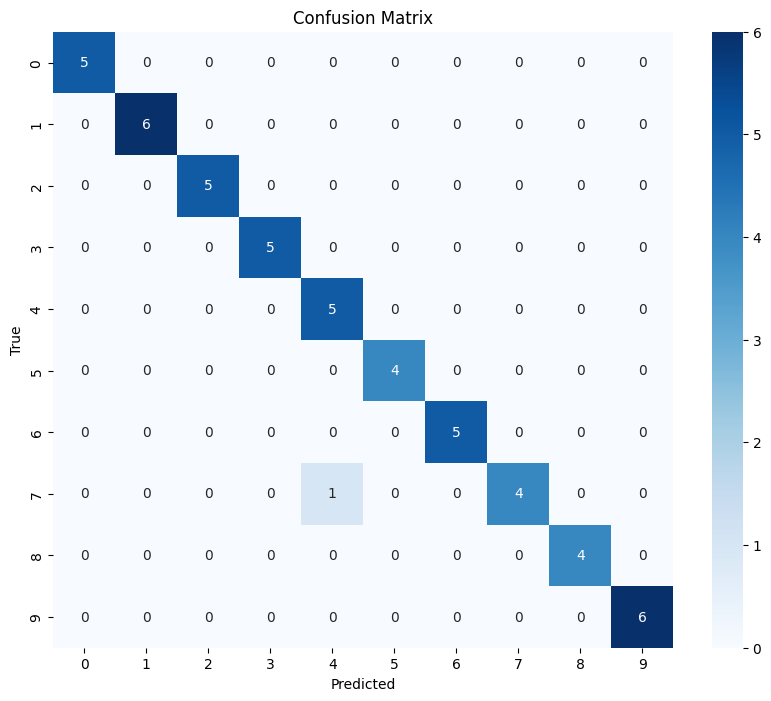

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [124]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

This model has an accuracy of 98%, with only a single mistake.

# Itteratie dead end 1

# Jelmar

Improving a model for a single label is usually not a good idea.

I hover need more iterations and now that the foundation of the supervised model is solid it is time to look at the RBM model.

To make it easier for the pytorch layers to predict what the RBM model want I will put 10 layers at the end like the 10 labels that the model trains on.

This should make it easier for the pytorch layer and it should also give me some insight on the RBM model itself, because by only training the RBM once I cannot see if it is overly complex, underly complex, overfit, underfit or anything else.

In [125]:
hidden_sizes = [364, 91, 45, 10]

In [126]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.62s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.37s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.42s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.42s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.38s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.46s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.43s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.52s
[BernoulliRBM] Iteration

In [127]:
with open('DBN_2B_D1.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [128]:
with open('DBN_2B_D1.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [129]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [130]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [174]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

As can be seen in the images above the boltzman machine starts to overfit on the training images.

In [131]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        self.rbm4 = nn.Linear(45, 10, bias=True)
        
        self.fc1 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.sigmoid(self.rbm4(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

    model.rbm4.weight.copy_(torch.tensor(RBMs[3].components_.T.T))
    model.rbm4.bias.copy_(torch.tensor(RBMs[3].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
for param in model.rbm4.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (rbm4): Linear(in_features=45, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
)


In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store loss and validation loss
train_losses_d1 = []
val_losses_d1 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses_d1.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses_d1.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.4352, Val Loss: 2.3095
Epoch [2/100], Loss: 2.3903, Val Loss: 2.2470
Epoch [3/100], Loss: 2.3535, Val Loss: 2.1605
Epoch [4/100], Loss: 2.3557, Val Loss: 2.0391
Epoch [5/100], Loss: 2.3817, Val Loss: 1.8977
Epoch [6/100], Loss: 2.4361, Val Loss: 1.7530
Epoch [7/100], Loss: 2.5337, Val Loss: 1.6040
Epoch [8/100], Loss: 2.6582, Val Loss: 1.4738
Epoch [9/100], Loss: 2.7589, Val Loss: 1.3734
Epoch [10/100], Loss: 2.8331, Val Loss: 1.2933
Epoch [11/100], Loss: 2.8939, Val Loss: 1.2275
Epoch [12/100], Loss: 2.9264, Val Loss: 1.1753
Epoch [13/100], Loss: 2.9627, Val Loss: 1.1302
Epoch [14/100], Loss: 2.9946, Val Loss: 1.0909
Epoch [15/100], Loss: 3.0282, Val Loss: 1.0577
Epoch [16/100], Loss: 3.0510, Val Loss: 1.0286
Epoch [17/100], Loss: 3.0453, Val Loss: 1.0029
Epoch [18/100], Loss: 3.0568, Val Loss: 0.9808
Epoch [19/100], Loss: 3.0643, Val Loss: 0.9604
Epoch [20/100], Loss: 3.0581, Val Loss: 0.9423
Epoch [21/100], Loss: 3.0548, Val Loss: 0.9256
Epoch [22/100], Loss: 

In [133]:
# Save the model
torch.save(model.state_dict(), 'model_d1.pth')
print("Model saved!")

Model saved!


In [134]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_d1.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6264\3964580165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_d1.pth'))


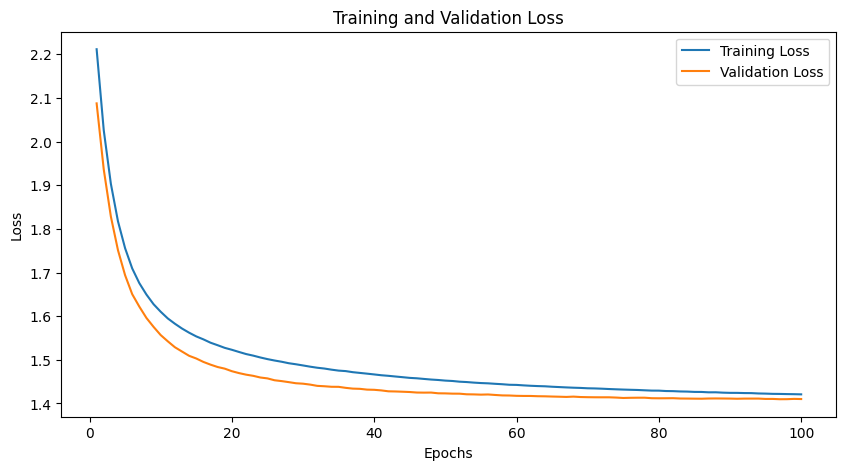

In [135]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

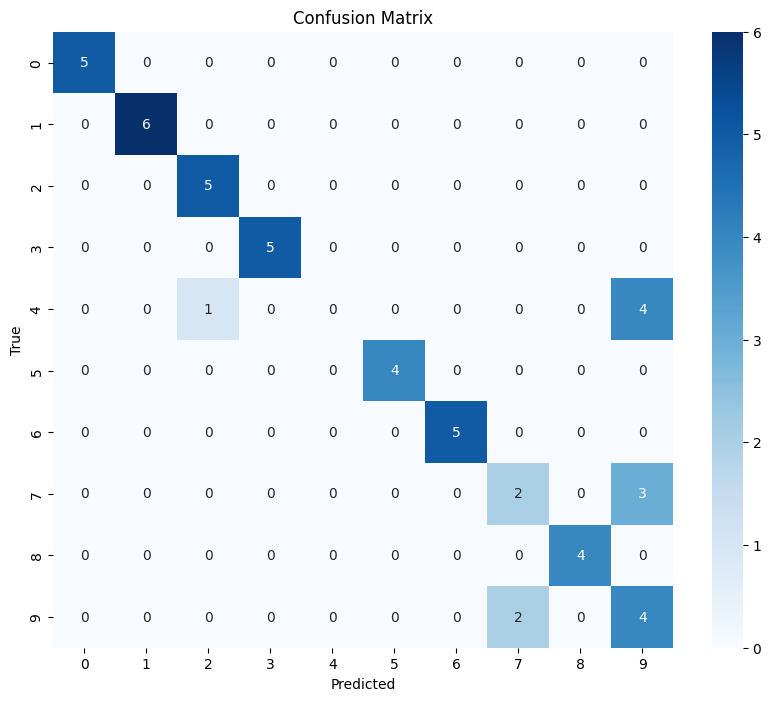

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       0.00      0.00      0.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       0.50      0.40      0.44         5
           8       1.00      1.00      1.00         4
           9       0.36      0.67      0.47         6

    accuracy                           0.80        50
   macro avg       0.77      0.81      0.78        50
weighted avg       0.76      0.80      0.77        50



d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Code\School\m_t\MT2B\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [136]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

The confusion matrixs has become worse because of the overfitting.

The F1 score has also become lower.

# Itteratie 2

# Jelmar

Since the model started to overfit last iteration when it became bigger, now needs to be investigated if the base model was not overfit already.

In [137]:
hidden_sizes = [364, 91, 45]

In [138]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 50, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.61s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.40s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.40s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.34s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.46s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.45s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.47s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.47s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.47s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.47s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.52s
[BernoulliRBM] Iteration

In [139]:
with open('DBN_2B_2.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [140]:
with open('DBN_2B_2.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [141]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [142]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [143]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar
The goal of the model is to reconise the numbers and not recreate them so it seems the model still tries too hard to get the perfect numbers.

In [144]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        
        self.fc1 = nn.Linear(45, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (fc1): Linear(in_features=45, out_features=10, bias=True)
)


In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss and validation loss
train_losses2 = []
val_losses2 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses2.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses2.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.2121, Val Loss: 2.0150
Epoch [2/100], Loss: 1.3604, Val Loss: 1.4942
Epoch [3/100], Loss: 0.8644, Val Loss: 1.0754
Epoch [4/100], Loss: 0.7125, Val Loss: 0.8198
Epoch [5/100], Loss: 0.6109, Val Loss: 0.6629
Epoch [6/100], Loss: 0.5414, Val Loss: 0.5598
Epoch [7/100], Loss: 0.4442, Val Loss: 0.4870
Epoch [8/100], Loss: 0.3855, Val Loss: 0.4336
Epoch [9/100], Loss: 0.3503, Val Loss: 0.3931
Epoch [10/100], Loss: 0.4273, Val Loss: 0.3591
Epoch [11/100], Loss: 0.3375, Val Loss: 0.3300
Epoch [12/100], Loss: 0.3260, Val Loss: 0.3065
Epoch [13/100], Loss: 0.3133, Val Loss: 0.2843
Epoch [14/100], Loss: 0.2942, Val Loss: 0.2695
Epoch [15/100], Loss: 0.2617, Val Loss: 0.2543
Epoch [16/100], Loss: 0.2051, Val Loss: 0.2410
Epoch [17/100], Loss: 0.2709, Val Loss: 0.2254
Epoch [18/100], Loss: 0.1947, Val Loss: 0.2172
Epoch [19/100], Loss: 0.2059, Val Loss: 0.2100
Epoch [20/100], Loss: 0.2056, Val Loss: 0.2000
Epoch [21/100], Loss: 0.1941, Val Loss: 0.1931
Epoch [22/100], Loss: 

In [146]:
# Save the model
torch.save(model.state_dict(), 'model_2.pth')
print("Model saved!")

Model saved!


In [147]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_2.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6264\1777792011.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pth'))


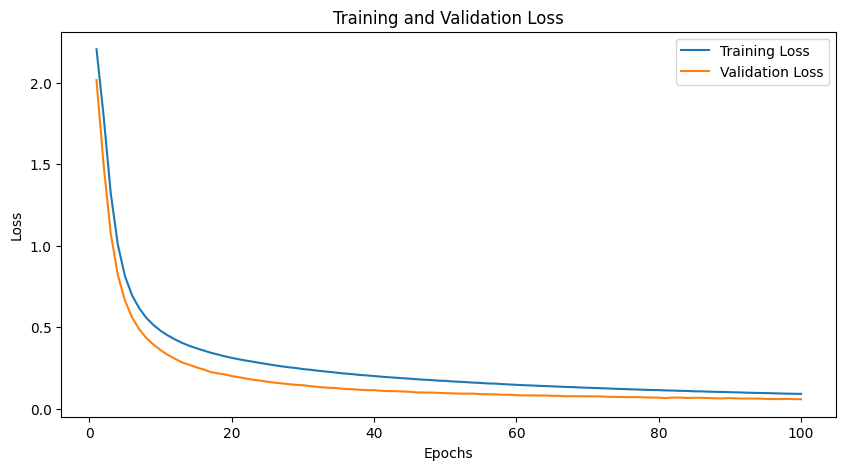

In [148]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

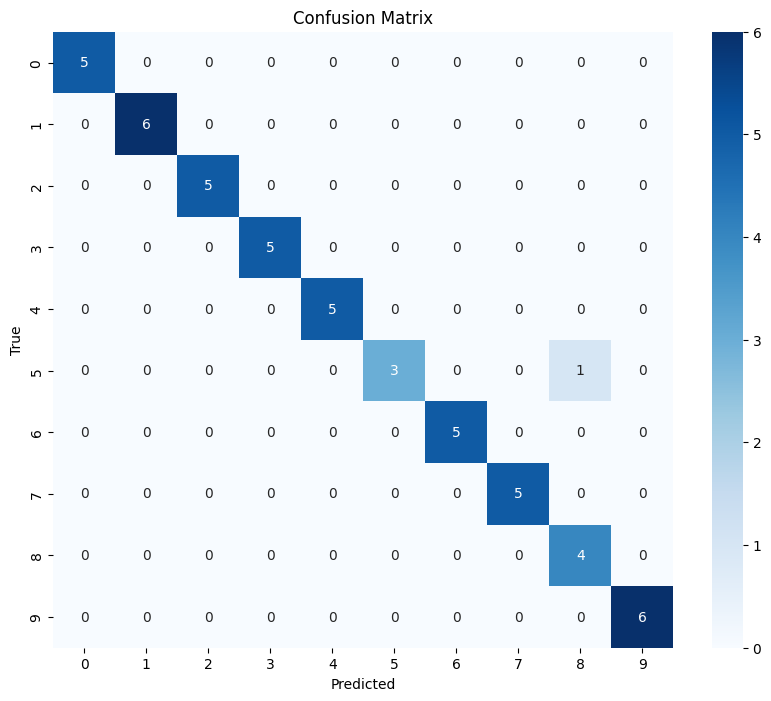

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.80      1.00      0.89         4
           9       1.00      1.00      1.00         6

    accuracy                           0.98        50
   macro avg       0.98      0.97      0.97        50
weighted avg       0.98      0.98      0.98        50



In [149]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Jelmar

There is only a single mistake left so every new itteration would be myself manualy overfitting on the validation data.

Hover, since the model was overfitting, the model can become more efficient and more generalised, while keeping or improving its perfomance.

# Itteratie 3

# Jelmar

The RBM model still seems to overfit and making it larger meant it overfit earlier as can be seen in "Itteratie Dead End 1", wich is why now a RBM will be removed from the Diep believe network.

In [150]:
hidden_sizes = [364, 91]

In [151]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 50, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.61s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.45s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.49s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.44s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.48s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.49s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.32s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.40s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.50s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.49s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.48s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.55s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.51s
[BernoulliRBM] Iteration

In [152]:
with open('DBN_2B_3.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [153]:
with open('DBN_2B_3.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [154]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [155]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))
        

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [156]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

# Jelmar

The model finaly seems to think abstract enough (in low detailed numbers) so that it would be easier for it to reconise numbers.

In [157]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        
        self.fc1 = nn.Linear(91, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (fc1): Linear(in_features=91, out_features=10, bias=True)
)


In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss and validation loss
train_losses3 = []
val_losses3 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses3.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses3.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 1.8286, Val Loss: 1.6323
Epoch [2/100], Loss: 1.0678, Val Loss: 0.9597
Epoch [3/100], Loss: 0.7586, Val Loss: 0.6682
Epoch [4/100], Loss: 0.5751, Val Loss: 0.5208
Epoch [5/100], Loss: 0.4602, Val Loss: 0.4344
Epoch [6/100], Loss: 0.3677, Val Loss: 0.3756
Epoch [7/100], Loss: 0.3533, Val Loss: 0.3292
Epoch [8/100], Loss: 0.2395, Val Loss: 0.3033
Epoch [9/100], Loss: 0.2277, Val Loss: 0.2716
Epoch [10/100], Loss: 0.1961, Val Loss: 0.2521
Epoch [11/100], Loss: 0.1848, Val Loss: 0.2342
Epoch [12/100], Loss: 0.1536, Val Loss: 0.2176
Epoch [13/100], Loss: 0.1341, Val Loss: 0.2041
Epoch [14/100], Loss: 0.1126, Val Loss: 0.1965
Epoch [15/100], Loss: 0.1055, Val Loss: 0.1857
Epoch [16/100], Loss: 0.1018, Val Loss: 0.1753
Epoch [17/100], Loss: 0.0850, Val Loss: 0.1686
Epoch [18/100], Loss: 0.0699, Val Loss: 0.1632
Epoch [19/100], Loss: 0.0700, Val Loss: 0.1586
Epoch [20/100], Loss: 0.0663, Val Loss: 0.1506
Epoch [21/100], Loss: 0.0586, Val Loss: 0.1481
Epoch [22/100], Loss: 

In [159]:
# Save the model
torch.save(model.state_dict(), 'model_3.pth')
print("Model saved!")

Model saved!


In [160]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model_3.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6264\848389358.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_3.pth'))


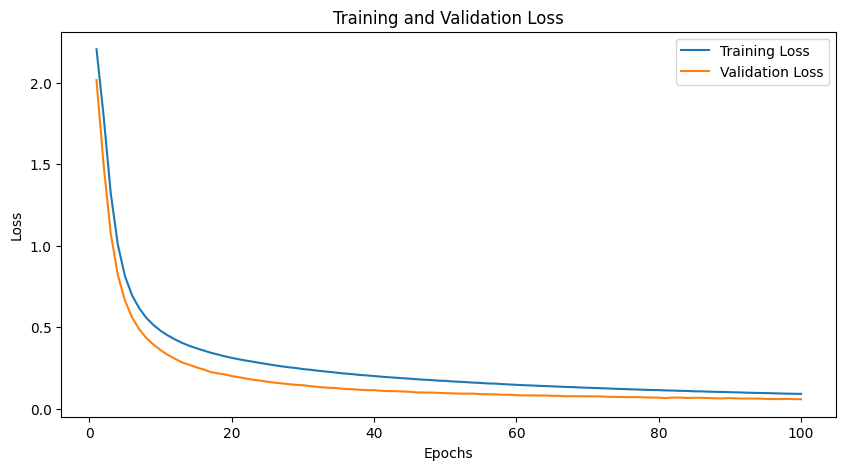

In [161]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Evaluate on the epochs.

Explain why the optimizer.

Evaluate on learning rate.

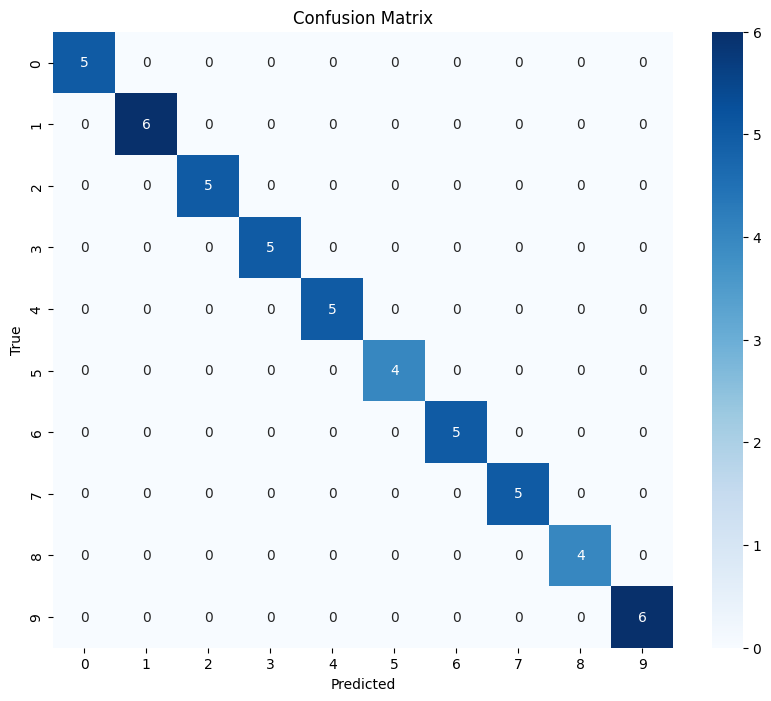

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [162]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))


# Jelmar

The model has a perfect score now and has significatly shrunk in size.

# Itteratie 4

If stratisfied split is not used the RBM still overfits, if stratisfied split is used then nothing changes because the score is already perfect and the size of the model stays the same, it will just generalize better.

In [163]:
hidden_sizes = [364, 91]

In [164]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 25, random_state = 42, verbose=1)    
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -159.31, time = 4.60s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.88, time = 5.39s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -115.38, time = 5.33s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -107.03, time = 5.40s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.59, time = 5.47s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -97.75, time = 5.46s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.37, time = 5.48s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.28, time = 5.46s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.30, time = 5.45s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.11, time = 5.47s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -86.23, time = 5.45s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -84.56, time = 5.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -83.44, time = 5.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -82.11, time = 5.53s
[BernoulliRBM] Iteration

In [165]:
with open('DBN_2B_4.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [166]:
with open('DBN_2B_4.pickle', 'rb') as file:
    RBMs = pickle.load(file)

In [167]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

In [168]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

In [169]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

In [170]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        
        # self.fc1 = nn.Linear(10, 10)
        self.fc1 = nn.Linear(91, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.nn.functional.silu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))

# Freeze the first layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (fc1): Linear(in_features=91, out_features=10, bias=True)
)


In [171]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss and validation loss
train_losses4 = []
val_losses4 = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses4.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses4.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 1.7654, Val Loss: 1.6730
Epoch [2/100], Loss: 1.0019, Val Loss: 1.0236
Epoch [3/100], Loss: 0.6325, Val Loss: 0.7075
Epoch [4/100], Loss: 0.4751, Val Loss: 0.5494
Epoch [5/100], Loss: 0.3239, Val Loss: 0.4528
Epoch [6/100], Loss: 0.3054, Val Loss: 0.3815
Epoch [7/100], Loss: 0.2446, Val Loss: 0.3353
Epoch [8/100], Loss: 0.1924, Val Loss: 0.2988
Epoch [9/100], Loss: 0.1499, Val Loss: 0.2728
Epoch [10/100], Loss: 0.1455, Val Loss: 0.2487
Epoch [11/100], Loss: 0.1368, Val Loss: 0.2295
Epoch [12/100], Loss: 0.1297, Val Loss: 0.2179
Epoch [13/100], Loss: 0.0888, Val Loss: 0.1995
Epoch [14/100], Loss: 0.0959, Val Loss: 0.1862
Epoch [15/100], Loss: 0.0678, Val Loss: 0.1755
Epoch [16/100], Loss: 0.0756, Val Loss: 0.1652
Epoch [17/100], Loss: 0.0657, Val Loss: 0.1612
Epoch [18/100], Loss: 0.0493, Val Loss: 0.1557
Epoch [19/100], Loss: 0.0433, Val Loss: 0.1475
Epoch [20/100], Loss: 0.0424, Val Loss: 0.1417
Epoch [21/100], Loss: 0.0354, Val Loss: 0.1357
Epoch [22/100], Loss: 

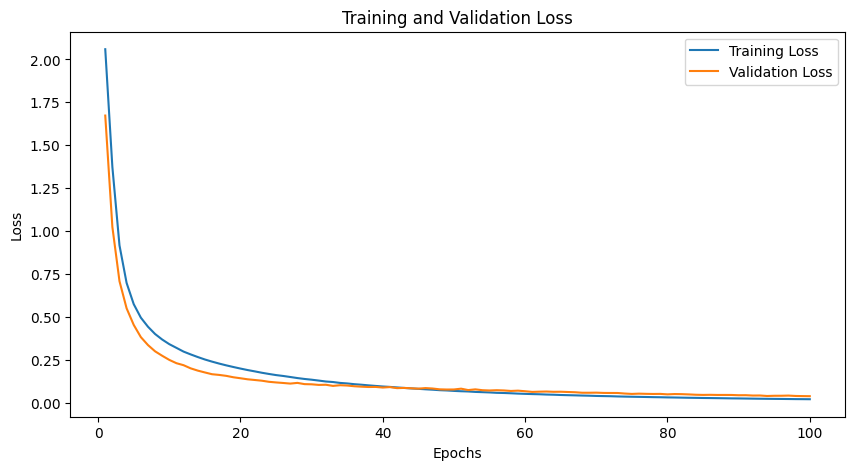

In [172]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses4, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses4, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

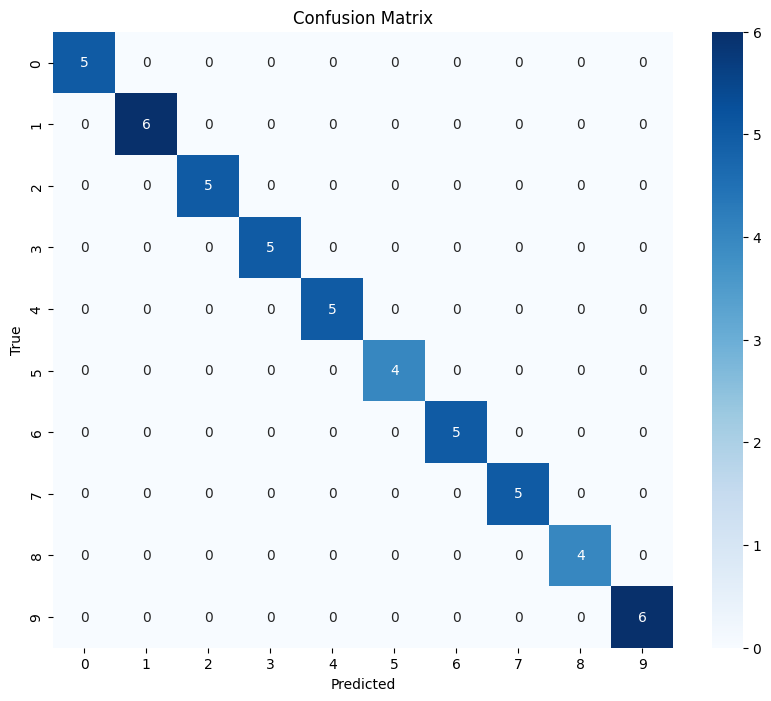

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [173]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))


# Itteratie 5

Evalueer het aantal epochs op het pytorch model.

# Conclusie

Evaluate on the metrics.

Compare final result to the null model.

Evaluate final model on the metrics (cross entropy or something).

Manualy grade the results of the image classification.